In [2]:
import os
audio_files = os.listdir("Language Detection Dataset")
for files in audio_files:
    print(files)
print(len(audio_files))

Kannada
Marathi
Punjabi
Telugu
Gujarati
Malayalam
Urdu
Tamil
Hindi
Bengali
10


In [3]:
import librosa
import numpy as np
import IPython.display as ipd
import matplotlib.pyplot as plt
import librosa.display
import seaborn as sns
import warnings
from glob import glob
import pandas as pd

In [4]:
def normalize_amplitude(y):
    """Normalize audio signal to -1 to 1 range."""
    return y / np.max(np.abs(y))

def fast_pitch_normalize(y, sr, target_pitch_hz=150.0):
    # Estimate pitch using YIN
    f0 = librosa.yin(y, fmin=librosa.note_to_hz('C2'), fmax=librosa.note_to_hz('C7'))
    mean_pitch = np.mean(f0)

    # Calculate semitone shift
    n_steps = librosa.hz_to_midi(target_pitch_hz) - librosa.hz_to_midi(mean_pitch)

    # Apply pitch shift
    y_shifted = librosa.effects.pitch_shift(y, sr=sr, n_steps=n_steps)
    return y_shifted

In [ ]:
root_directory = "Language Detection Dataset"
def feature_extractor(file):
    audio_data,sample_rate = librosa.load(file)
    audio_data = librosa.effects.trim(audio_data)
    audio_data = normalize_amplitude(audio_data)
    audio_data = fast_pitch_normalize(audio_data, sample_rate)
    mfcc_feature = librosa.feature.mfcc(y=audio_data,sr=sample_rate,n_mfcc=40)
    scaled_feature = np.mean(mfcc_feature.T,axis=0)
    return scaled_feature

In [6]:
category = os.listdir(root_directory)


In [7]:
from tqdm import tqdm
import pickle
ParameterError = librosa.util.exceptions.ParameterError

for folder in os.listdir(root_directory):
    if folder in ["Punjabi"]:
        continue
    folder_path = os.path.join(root_directory,folder) 
        
    mfccs_feature = []
    classes = []
    for file in tqdm(os.listdir(folder_path)[:5000], desc=f"Processing {folder}"):

        try:
            file_path = os.path.join(folder_path,file)
            mfccs_feature.append(feature_extractor(file_path))
            classes.append(folder)
        except:
            pass
            
    with open(f"{folder}_features.pkl", "wb") as f:
        pickle.dump({'features': mfccs_feature, 'class': folder}, f)
        print(f"For language {folder}: Features = {len(mfccs_feature)}")
    print(folder, "done")


Processing Kannada:   4%|▍         | 209/5000 [00:08<03:06, 25.66it/s]/tmp/ipykernel_305538/3179299457.py:3: RuntimeWarning: invalid value encountered in divide
  return y / np.max(np.abs(y))
Processing Kannada: 100%|██████████| 5000/5000 [03:02<00:00, 27.35it/s]


For language Kannada: Features = 4955
Kannada done


Processing Marathi: 100%|██████████| 5000/5000 [04:01<00:00, 20.70it/s]


For language Marathi: Features = 4993
Marathi done


Processing Telugu: 100%|██████████| 5000/5000 [03:31<00:00, 23.63it/s]


For language Telugu: Features = 5000
Telugu done


Processing Gujarati:  59%|█████▊    | 2931/5000 [01:58<01:23, 24.68it/s]/tmp/ipykernel_305538/4162959212.py:3: UserWarning: PySoundFile failed. Trying audioread instead.
  audio_data,sample_rate = librosa.load(file)
/home/teaching/miniconda3/envs/torch_gpu/lib/python3.10/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/tmp/ipykernel_305538/3179299457.py:3: RuntimeWarning: invalid value encountered in divide
  return y / np.max(np.abs(y))
Processing Gujarati: 100%|██████████| 5000/5000 [03:21<00:00, 24.78it/s]


For language Gujarati: Features = 4982
Gujarati done


Processing Malayalam:  34%|███▍      | 1702/5000 [01:11<02:26, 22.46it/s]/home/teaching/miniconda3/envs/torch_gpu/lib/python3.10/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=361
  warnings.warn(
Processing Malayalam: 100%|██████████| 5000/5000 [03:30<00:00, 23.74it/s]


For language Malayalam: Features = 4999
Malayalam done


Processing Urdu: 100%|██████████| 5000/5000 [03:54<00:00, 21.34it/s]


For language Urdu: Features = 4971
Urdu done


Processing Tamil: 100%|██████████| 5000/5000 [03:37<00:00, 22.98it/s]


For language Tamil: Features = 4983
Tamil done


Processing Hindi: 100%|██████████| 5000/5000 [03:21<00:00, 24.80it/s]


For language Hindi: Features = 4953
Hindi done


Processing Bengali: 100%|██████████| 5000/5000 [03:43<00:00, 22.40it/s]

For language Bengali: Features = 4992
Bengali done


In [7]:
print(len(mfccs_feature))

34880


In [8]:
import pickle
with open("mfccs_feature_corrected.pkl", "wb") as f:
    pickle.dump(mfccs_feature, f)

In [9]:
with open("classes_corrected.pkl", "wb") as f:
    pickle.dump(classes, f)

In [10]:
df = pd.DataFrame({'MFCC_Features': mfccs_feature, 'Class': classes})
df.shape

(34880, 2)

In [11]:
new_df = df.sample(44999)
new_df.head()

ValueError: Cannot take a larger sample than population when 'replace=False'

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout,Dense

In [ ]:
lbl = LabelEncoder()
y = lbl.fit_transform(new_df['Class'])
X = np.array(new_df['MFCC_Features'].tolist())
y = np.array(y.tolist())

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42, stratify=y)

In [ ]:
model = Sequential()
model.add(Dense(100,activation='relu',input_shape=(40,)))
model.add(Dropout(0.2))

model.add(Dense(128,activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(225,activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(10,activation='softmax'))

In [ ]:
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])
history = model.fit(X_train,y_train,epochs=40,batch_size=32,validation_data=(X_test,y_test))


Epoch 1/40
1125/1125 [==============================] - 3s 2ms/step - loss: 1.8157 - accuracy: 0.5186 - val_loss: 0.5528 - val_accuracy: 0.7857
Epoch 2/40
1125/1125 [==============================] - 2s 2ms/step - loss: 0.5956 - accuracy: 0.7712 - val_loss: 0.3459 - val_accuracy: 0.8408
Epoch 3/40
1125/1125 [==============================] - 2s 2ms/step - loss: 0.4344 - accuracy: 0.8136 - val_loss: 0.2913 - val_accuracy: 0.8566
Epoch 4/40
1125/1125 [==============================] - 2s 2ms/step - loss: 0.3746 - accuracy: 0.8329 - val_loss: 0.2462 - val_accuracy: 0.8662
Epoch 5/40
1125/1125 [==============================] - 2s 2ms/step - loss: 0.3417 - accuracy: 0.8426 - val_loss: 0.2411 - val_accuracy: 0.8740
Epoch 6/40
1125/1125 [==============================] - 2s 2ms/step - loss: 0.3210 - accuracy: 0.8510 - val_loss: 0.2225 - val_accuracy: 0.8742
Epoch 7/40
1125/1125 [==============================] - 2s 2ms/step - loss: 0.3055 - accuracy: 0.8529 - val_loss: 0.2247 - val_accuracy:

<Axes: >

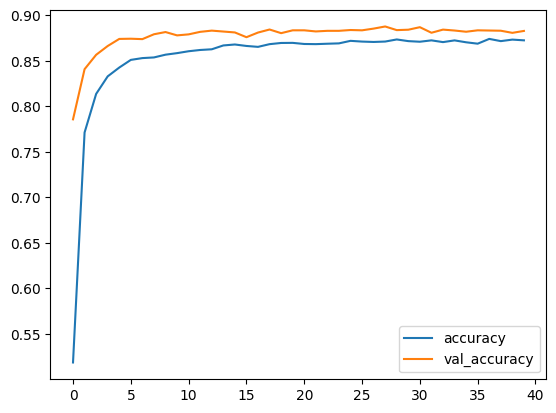

In [ ]:
history_df = pd.DataFrame({'accuracy': history.history['accuracy'], 'val_accuracy': history.history['val_accuracy']})
history_df.plot()

In [ ]:
model.evaluate(X_test,y_test)


282/282 [==============================] - 0s 738us/step - loss: 0.1924 - accuracy: 0.8828


[0.19237348437309265, 0.882777750492096]

In [ ]:
y_pred = model.predict(X_test)
y_pred = (y_pred>0.5).astype(int)
y_pred = np.argmax(y_pred,axis=1)
y_pred

282/282 [==============================] - 0s 687us/step


array([9, 3, 7, ..., 7, 5, 3], dtype=int64)

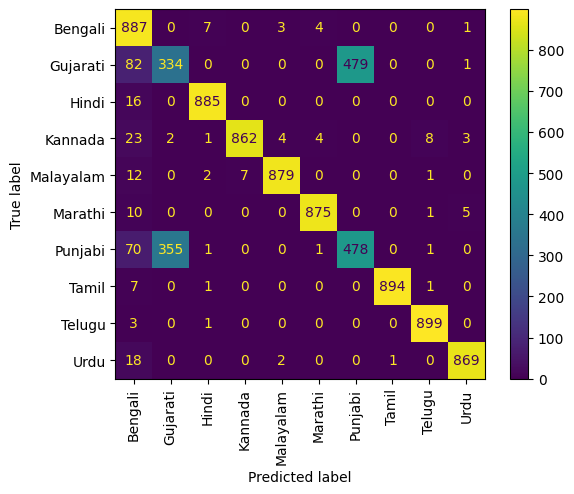

In [ ]:
cnf = confusion_matrix(y_test,y_pred)
ConfusionMatrixDisplay(cnf,display_labels=lbl.classes_).plot()
plt.xticks(rotation=90)
plt.show()

In [ ]:
y_pred = model.predict(X_test)
y_pred = (y_pred>0.5).astype(int)
y_pred = np.argmax(y_pred,axis=1)
y_pred


282/282 [==============================] - 0s 670us/step


array([9, 3, 7, ..., 7, 5, 3], dtype=int64)

In [ ]:
lbl = LabelEncoder()
y = lbl.fit_transform(new_df['Class'])
X = np.array(new_df['MFCC_Features'].tolist())
y = np.array(y.tolist())

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42, stratify=y)